In [1]:
import os
import time

import cv2
import imutils
import numpy as np

from visualize import *

root = os.getcwd()

In [5]:
labelsPath = os.path.join(root, "yolo_predictor/custom.names")
LABELS = open(labelsPath).read().strip().split("\n")

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.join(root, "yolo_predictor/yolov3_custom_9700.weights")
configPath = os.path.join(root, "yolo_predictor/cfg/yolov3-custom.cfg")

# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

[INFO] loading YOLO from disk...


In [6]:
vs = cv2.VideoCapture("cut.mp4")
writer = None
(W, H) = (None, None)
# try to determine the total number of frames in the video file
try:
    prop = (
        cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
    )
    total = int(vs.get(prop))
    print(f"[INFO] {total} total frames in video")
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    print("[INFO] no approx. completion time can be provided")
    total = -1

[INFO] 240 total frames in video


/Users/ssubramanian/suraj/EmotionDetection/transforms/functional.py:60: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[INFO] single frame took 0.5783 seconds
[INFO] estimated total time to finish: 138.7855
[INFO] cleaning up...


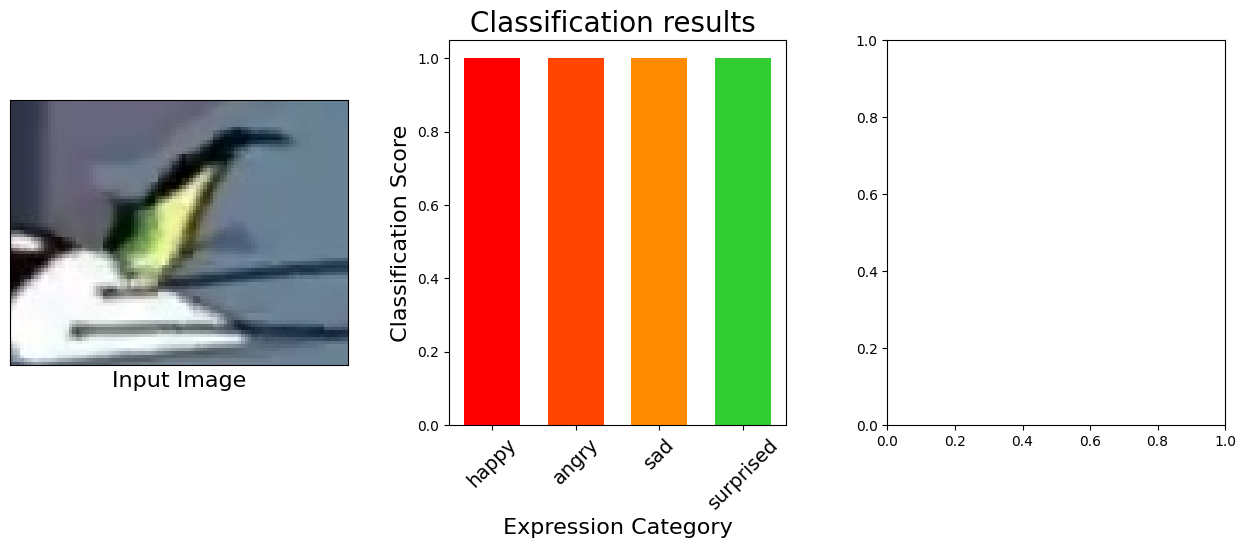

In [7]:
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break
    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            # draw a bounding box rectangle and label on the frame
            color = [int(c) for c in COLORS[classIDs[i]]]
            face_image = frame[y : y + h, x : x + w]
            path = os.path.join(root, "temp", "pic.jpg")
            cv2.imwrite(path, face_image)
            emotion = predictor(path)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = f"{LABELS[classIDs[i]]}: {confidences[i]:.4f}"
            text2 = f"{emotion}"
            cv2.putText(frame, text, (x, y - 22), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            cv2.putText(frame, text2, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MP4V")
        writer = cv2.VideoWriter(
            "output.mp4", fourcc, 30, (frame.shape[1], frame.shape[0]), True
        )
        # some information on processing single frame
        if total > 0:
            elap = end - start
            print(f"[INFO] single frame took {elap:.4f} seconds")
            print(f"[INFO] estimated total time to finish: {elap * total:.4f}")
    # write the output frame to disk
    writer.write(frame)
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()